# VARIMA


In [2]:
# Load the saved model and make predictions on the test data    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.serialize import model_to_json, model_from_json
from prophet.utilities import regressor_coefficients
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [3]:
# Import the data 
def load_and_prepare_data(file_path):
    """
    Load energy prices data from a CSV file, ensure chronological order, and convert 'Date' to datetime.
    """
    df = pd.read_csv(file_path)
    df.sort_values('Date', inplace=True)
    # Convert 'date' column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    #df.set_index('Date', inplace=True)
    df = pd.DataFrame(df)
    return df

In [9]:
# Define the future covariates columns from your dataframe
future_covariates_columns = ['Solar_radiation (W/m2)', 'Wind_speed (m/s)', 'Temperature (°C)', 
                             'Biomass (GWh)', 'Hard_coal (GWh)', 'Hydro (GWh)', 'Lignite (GWh)', 
                             'Natural_gas (GWh)', 'Other (GWh)', 'Pumped_storage_generation (GWh)', 
                             'Solar_energy (GWh)', 'Wind_offshore (GWh)', 'Wind_onshore (GWh)', 
                             'Net_total_export_import (GWh)', 'BEV_vehicles', 'Oil_price (EUR)', 
                             'TTF_gas_price (€/MWh)', 'Nuclear_energy (GWh)']

In [10]:
# Load in the train and test data
train_df = load_and_prepare_data('../../data/Final_data/train_df.csv')
test_df = load_and_prepare_data('../../data/Final_data/test_df.csv')

# Concatenate the train and test data
df = pd.concat([train_df, test_df])
df['Date'] = pd.to_datetime(df['Date'])

df

,Date,Day_ahead_price (€/MWh),Solar_radiation (W/m2),Wind_speed (m/s),Temperature (°C),Biomass (GWh),Hard_coal (GWh),Hydro (GWh),Lignite (GWh),Natural_gas (GWh),Other (GWh),Pumped_storage_generation (GWh),Solar_energy (GWh),Wind_offshore (GWh),Wind_onshore (GWh),Net_total_export_import (GWh),BEV_vehicles,Oil_price (EUR),TTF_gas_price (€/MWh),Nuclear_energy (GWh)
0,2012-01-01,18.19,14.75,4.95,8.39,98.605,108.454,51.011,325.337,188.811,54.040,19.314,6.263,3.404,235.467,54.662,6,99.64,21.10,250.979
1,2012-01-02,33.82,15.12,5.00,7.41,98.605,222.656,51.862,343.168,229.293,54.166,28.892,6.312,3.350,231.772,-64.477,6,100.04,20.00,258.671
2,2012-01-03,35.03,31.88,7.77,5.23,98.605,162.204,48.851,336.773,241.297,53.518,21.072,24.226,7.292,504.484,-35.078,6,100.44,20.90,271.495
3,2012-01-04,32.16,25.21,8.04,4.78,98.605,189.633,47.101,323.976,252.289,52.194,28.300,14.157,7.828,541.528,22.924,6,103.15,21.40,270.613
4,2012-01-05,20.35,13.46,9.98,4.23,98.605,175.733,45.854,327.502,259.018,52.179,31.887,4.728,8.280,572.819,35.618,6,103.92,21.30,287.555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754,2024-07-24,66.61,225.04,3.47,17.54,110.007,43.469,85.857,199.246,194.291,54.026,20.934,325.285,49.360,179.921,-168.705,992,75.75,32.63,0.000
755,2024-07-25,78.34,272.71,2.12,17.85,110.410,50.676,82.632,195.983,209.610,52.963,18.766,394.116,51.053,42.885,-194.496,992,76.36,31.70,0.000
756,2024-07-26,93.04,172.33,2.60,19.09,110.852,42.333,79.531,205.273,205.773,52.616,19.081,256.246,40.449,129.267,-241.786,993,75.21,32.20,0.000
757,2024-07-27,80.74,176.67,2.05,19.63,110.479,33.307,74.958,184.012,216.412,50.927,18.856,244.051,2.180,32.001,-251.655,992,74.79,32.90,0.000


In [11]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Day_ahead_price (€/MWh)'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -3.731301392799671
p-value: 0.0036938048562443907


In [12]:
from statsmodels.tsa.stattools import kpss

kpss_stat, p_value, lags, crit_values = kpss(df['Day_ahead_price (€/MWh)'])
print('KPSS Statistic:', kpss_stat)
print('p-value:', p_value)


KPSS Statistic: 3.5800671523012446
p-value: 0.01


/var/folders/8w/b_0gc01d70g6h4k62sb7ytyw0000gn/T/ipykernel_81725/2126859154.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, p_value, lags, crit_values = kpss(df['Day_ahead_price (€/MWh)'])


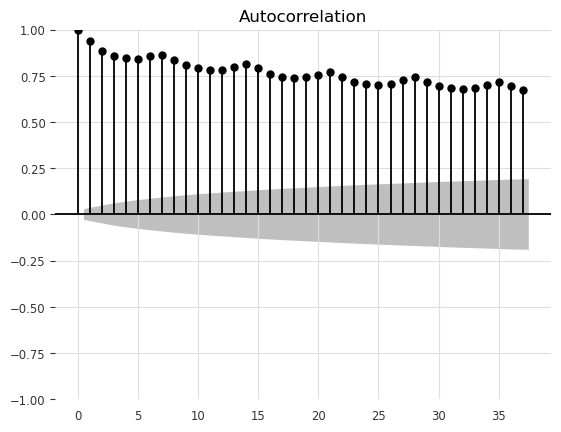

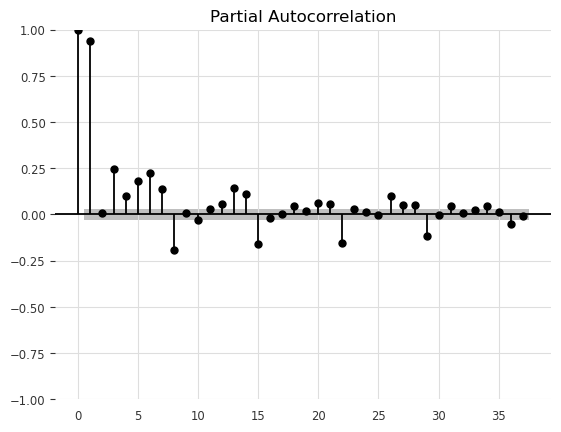

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming 'df' contains your time series data
plot_acf(df['Day_ahead_price (€/MWh)'])
plt.show()

plot_pacf(df['Day_ahead_price (€/MWh)'])
plt.show()


In [33]:
# Import necessary libraries
import pandas as pd
from darts import TimeSeries
from darts.models import VARIMA
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape, mae, rmse, mse
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Combine the covariates to create a multivariate covariate series (covariates only)
covariates_train_series = TimeSeries.from_dataframe(
    train_df, 'Date', future_covariates_columns).astype('float32')

# Create the target series (Day-ahead price)
series_train = TimeSeries.from_dataframe(train_df, 'Date', 'Day_ahead_price (€/MWh)').astype('float32')
series_test = TimeSeries.from_dataframe(test_df, 'Date', 'Day_ahead_price (€/MWh)').astype('float32')

# Scale the target and covariates separately
scaler_target = Scaler()
scaler_covariates = Scaler()

# Fit and transform the training target and covariates series
series_train_scaled = scaler_target.fit_transform(series_train)
covariates_train_scaled = scaler_covariates.fit_transform(covariates_train_series)

# Transform the test target series
series_test_scaled = scaler_target.transform(series_test)

# Create full covariates time series for forecasting
future_covariates_full = TimeSeries.from_dataframe(
    df, 'Date', future_covariates_columns, fill_missing_dates=True, freq="D"
).astype('float32')

# Slice the covariates to match the test set for prediction
future_covariates_for_prediction = future_covariates_full.slice(
    series_test.start_time() - pd.DateOffset(days=(200 - 1)), series_test.end_time()
)

# Scale the covariates for prediction
future_covariates_for_prediction_scaled = scaler_covariates.transform(future_covariates_for_prediction)

# Combine the scaled target and covariates for the VARIMA model (multivariate time series)
combined_train_series = series_train_scaled.stack(covariates_train_scaled)

# Initialize and fit the VARIMA model with the multivariate series
model = VARIMA(p=2, d=1, q=2)  # Adjust p, d, q based on your ACF/PACF analysis
model.fit(combined_train_series)

# Forecasting
n = len(series_test_scaled)
forecast_scaled = model.predict(n=n)

# Inverse transform the forecast to original scale (for the target variable only)
forecast = scaler_target.inverse_transform(forecast_scaled)
test_series = scaler_target.inverse_transform(series_test_scaled)

# Plot the actual vs forecasted data
fig = go.Figure()

# Add actual test data
fig.add_trace(go.Scatter(x=test_series.time_index,
                         y=test_series.values().squeeze(),
                         mode='lines', name='Actual', line=dict(color='blue')))

# Add forecasted data
fig.add_trace(go.Scatter(x=forecast.time_index,
                         y=forecast.values().squeeze(),
                         mode='lines', name='Forecast', line=dict(color='red')))

# Update layout
fig.update_layout(title='VARIMA Model - Forecast',
                  xaxis_title='Date', yaxis_title='Day Ahead Price (€/MWh)',
                  legend=dict(x=1, y=1, xanchor='right', yanchor='top', bordercolor='black', borderwidth=1),
                  template='plotly_white')

fig.show()

# Calculate error metrics
print('Error Metrics on Test Set:')
print(f'Mean Absolute Percentage Error (MAPE): {mape(test_series, forecast):.2f}%')
print(f'Mean Absolute Error (MAE): {mae(test_series, forecast):.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse(test_series, forecast):.2f}')
print(f'Mean Squared Error (MSE): {mse(test_series, forecast):.2f}')


/Users/skyfano/Documents/Masterarbeit/Prediction_of_energy_prices/master_thesis/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/Users/skyfano/Documents/Masterarbeit/Prediction_of_energy_prices/master_thesis/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")


KeyboardInterrupt: 

In [13]:
# Import necessary libraries
import pandas as pd
from darts import TimeSeries
from darts.models import VARIMA
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape, mae, rmse, mse
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Combine the covariates to create a multivariate covariate series (covariates only)
covariates_train_series = TimeSeries.from_dataframe(
    train_df, 'Date', future_covariates_columns).astype('float32')

# Create the target series (Day-ahead price)
series_train = TimeSeries.from_dataframe(train_df, 'Date', 'Day_ahead_price (€/MWh)').astype('float32')
series_test = TimeSeries.from_dataframe(test_df, 'Date', 'Day_ahead_price (€/MWh)').astype('float32')

# Scale the target and covariates separately
scaler_target = Scaler()
scaler_covariates = Scaler()

# Fit and transform the training target and covariates series
series_train_scaled = scaler_target.fit_transform(series_train)
covariates_train_scaled = scaler_covariates.fit_transform(covariates_train_series)

# Transform the test target series
series_test_scaled = scaler_target.transform(series_test)

# Combine the scaled target and covariates for the VARIMA model (multivariate time series)
combined_train_series = series_train_scaled.stack(covariates_train_scaled)

# Initialize and fit the VARIMA model with the multivariate series
model = VARIMA(p=1, d=1, q=0)  # Simpler VAR model
 # Adjust p, d, q based on your ACF/PACF analysis
model.fit(combined_train_series)

# Forecasting
n = len(series_test_scaled)
forecast_scaled = model.predict(n=n)

# Inverse transform the forecast to original scale (for the target variable only)
forecast = scaler_target.inverse_transform(forecast_scaled)
test_series = scaler_target.inverse_transform(series_test_scaled)

# Plot the actual vs forecasted data
fig = go.Figure()

# Add actual test data
fig.add_trace(go.Scatter(x=test_series.time_index,
                         y=test_series.values().squeeze(),
                         mode='lines', name='Actual', line=dict(color='blue')))

# Add forecasted data
fig.add_trace(go.Scatter(x=forecast.time_index,
                         y=forecast.values().squeeze(),
                         mode='lines', name='Forecast', line=dict(color='red')))

# Update layout
fig.update_layout(title='VARIMA Model - Forecast',
                  xaxis_title='Date', yaxis_title='Day Ahead Price (€/MWh)',
                  legend=dict(x=1, y=1, xanchor='right', yanchor='top', bordercolor='black', borderwidth=1),
                  template='plotly_white')

fig.show()

# Calculate error metrics
print('Error Metrics on Test Set:')
print(f'Mean Absolute Percentage Error (MAPE): {mape(test_series, forecast):.2f}%')
print(f'Mean Absolute Error (MAE): {mae(test_series, forecast):.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse(test_series, forecast):.2f}')
print(f'Mean Squared Error (MSE): {mse(test_series, forecast):.2f}')


/Users/skyfano/Documents/Masterarbeit/Prediction_of_energy_prices/master_thesis/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")
